### Load the libraries

In [1]:
# Import math and CV libs
from helper_functions import get_hog_features, bin_spatial, color_hist, slide_window, draw_boxes, convert_image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
%matplotlib inline

### Show images

In [2]:
def show_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
def get_dataset(rootdir):
    images = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(subdir, file))
                
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))

In [4]:
rootdir = './dataset/vehicles'
vehicles = get_dataset(rootdir)
print(len(vehicles))

8792


In [5]:
rootdir = './dataset/non-vehicles'
non_vehicles = get_dataset(rootdir)
print(len(non_vehicles))

8968


8968


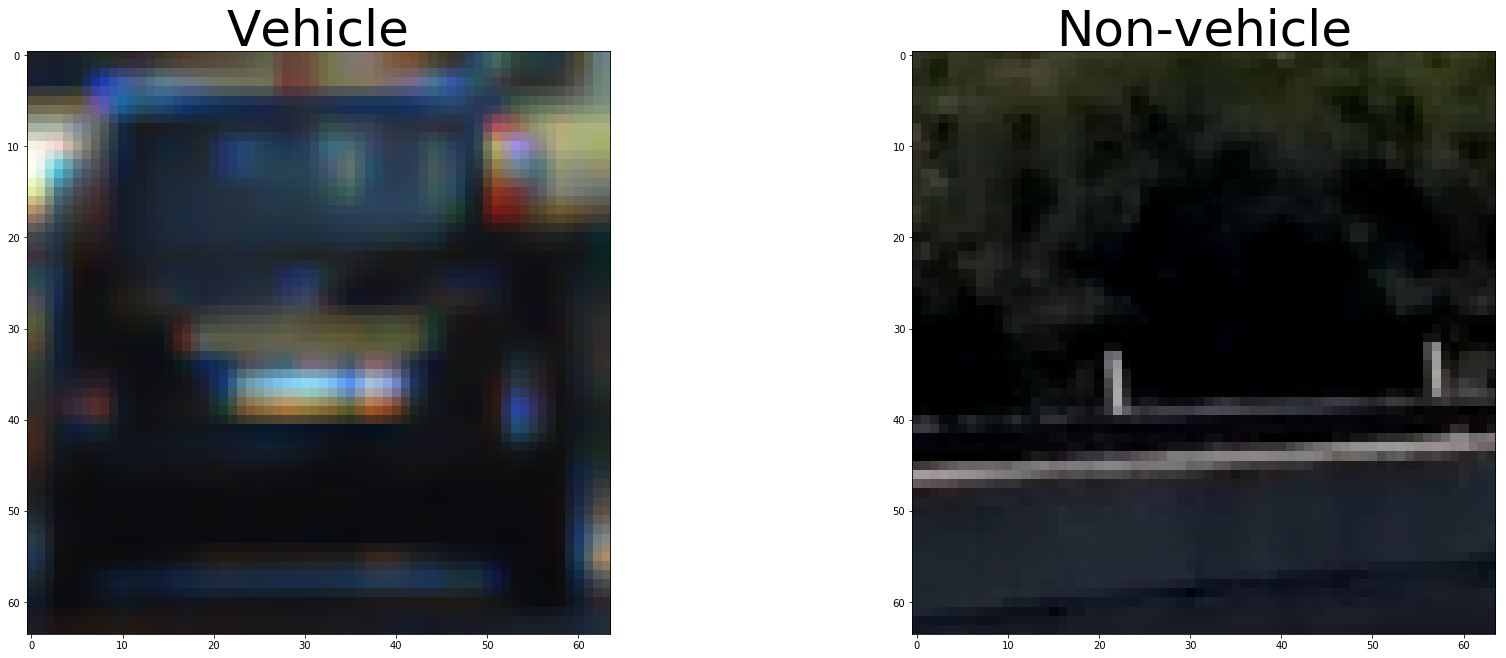

In [6]:
image1 = random.choice(vehicles)
image2 = random.choice(non_vehicles)
show_images(image1, "Vehicle", image2, "Non-vehicle")
print(len(non_vehicles))

### Extract features from a list of images

In [7]:
class Parameters():
    color_space='RGB'
    spatial_size=(32, 32)
    hist_bins=8
    orient=9
    pix_per_cell=8
    cell_per_block=2
    hog_channel=0
    hist_range = (0, 256)
    spatial_feat=True
    hist_feat=True
    hog_feat=True
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                 hist_bins=8, orient=9, 
                 pix_per_cell=8, cell_per_block=2, hog_channel=0, scale = 1.5,hist_range = (0, 256),
                 spatial_feat=True, hist_feat=True, hog_feat=True):
        # HOG parameters
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.scale = scale
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.hist_range = hist_range
    
        
    

In [8]:
def extract_features(img, params):
        file_features = []
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        feature_image = convert_image(img, params.color_space)    

        if params.spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=params.spatial_size)
            file_features.append(spatial_features)
        if params.hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=params.hist_bins)
            file_features.append(hist_features)
        if params.hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if params.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        params.orient, params.pix_per_cell, params.cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,params.hog_channel], params.orient, 
                            params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        # Return list of feature vectors
        return np.concatenate(file_features)

In [9]:
params = Parameters(
            color_space = 'YCrCb',
            spatial_size = (16, 16),
            orient = 8,
            pix_per_cell = 8,
            cell_per_block = 2,
            hog_channel = 'ALL',
            hist_bins = 32,
            scale = 1.5,
            spatial_feat=True, 
            hist_feat=True, 
            hog_feat=True
        )

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,0,'Non-Car Spatial Features')

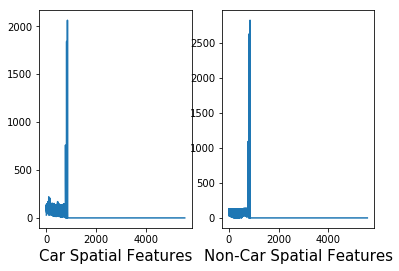

In [10]:
vehicle = image1
non_vehicle = image2

car_spatial_features = extract_features(vehicle, params)
notcar_spatial_features = extract_features(non_vehicle, params)
plt.figure()
plt.subplot(121)
plt.plot((car_spatial_features))
plt.xlabel("Car Spatial Features",fontsize=15)

plt.subplot(122)
plt.plot(notcar_spatial_features)
plt.xlabel("Non-Car Spatial Features",fontsize=15)



### Show Hog features

In [11]:
def show_hog(vehicle, non_vehicle, params):
    _,vehicle_hog = get_hog_features(vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    _,non_vehicle_hog = get_hog_features(non_vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.set_title('Vehicle')
    ax1.imshow(vehicle, cmap='gray')
    ax2.set_title('Vehicle hog')
    ax2.imshow(vehicle_hog, cmap='gray')
    ax3.set_title('Non-vehicle')
    ax3.imshow(non_vehicle, cmap='gray')
    ax4.set_title('Non-vehicle hog')
    ax4.imshow(non_vehicle_hog, cmap='gray')

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


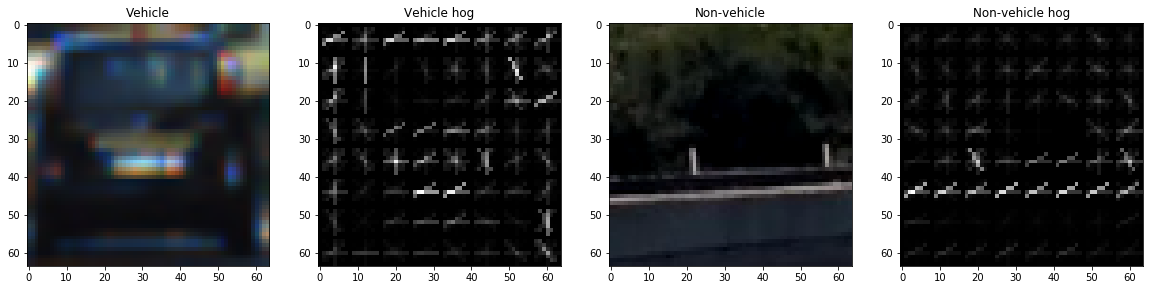

In [12]:
show_hog(vehicle, non_vehicle, params)

### SVM

In [13]:
sample_size = 8750
cars = vehicles[0:sample_size]
notcars = non_vehicles[0:sample_size]

car_features = list(map(lambda img: extract_features(img, params), cars))
notcar_features = list(map(lambda img: extract_features(img, params), notcars))


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
13.63 Seconds to train SVC...
Test Accuracy of SVC =  0.992


### Finding the cars

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


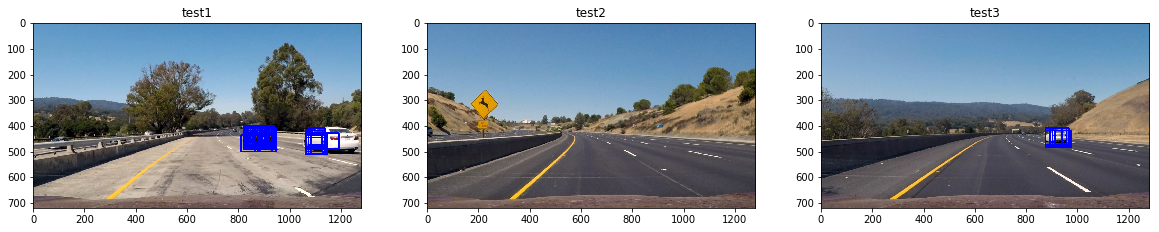

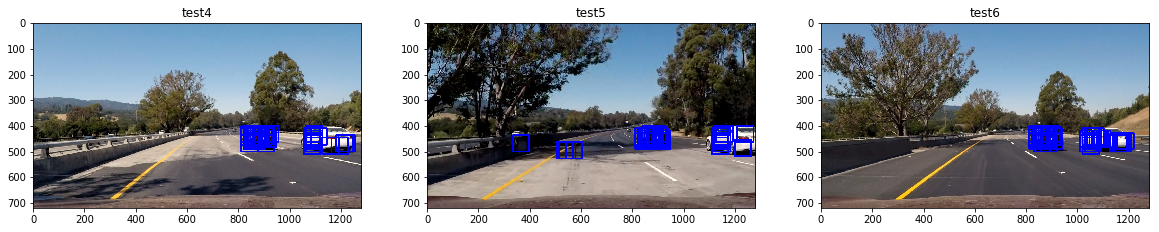

In [14]:
def findCars(img, svc, scaler, params, y_start_stop=[400, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    windows_list = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = svc.predict(scaled_features)
        if pred == 1:
            windows_list.append(window)
    return windows_list


#Run test images
test_images = ['./test_images/test1.jpg','./test_images/test2.jpg','./test_images/test3.jpg','./test_images/test4.jpg','./test_images/test5.jpg','./test_images/test6.jpg']
draw_images = []
for test_image in test_images:
    img = cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB)
    windows_list = findCars(img, svc, X_scaler, params)
    out_img = draw_boxes(img, windows_list)
    draw_images.append(out_img)
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('test1')
ax1.imshow(draw_images[0])
ax2.set_title('test2')
ax2.imshow(draw_images[1])
ax3.set_title('test3')
ax3.imshow(draw_images[2])
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(20,10))
ax4.set_title('test4')
ax4.imshow(draw_images[3])
ax5.set_title('test5')
ax5.imshow(draw_images[4])
ax6.set_title('test6')
ax6.imshow(draw_images[5])


### Multiple detections and False positives

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [16]:
from scipy.ndimage.measurements import label

def heat_threshold(img, threshold, svc, X_scaler, windows_list, params):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


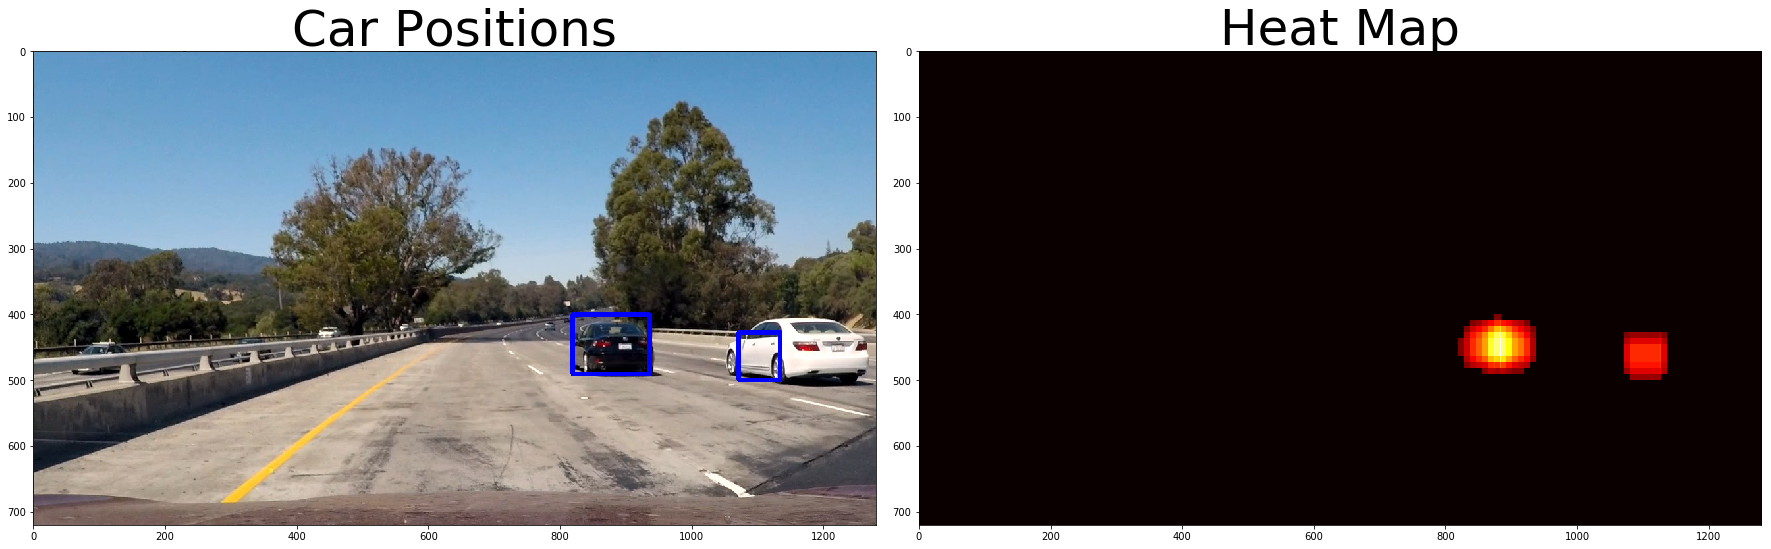

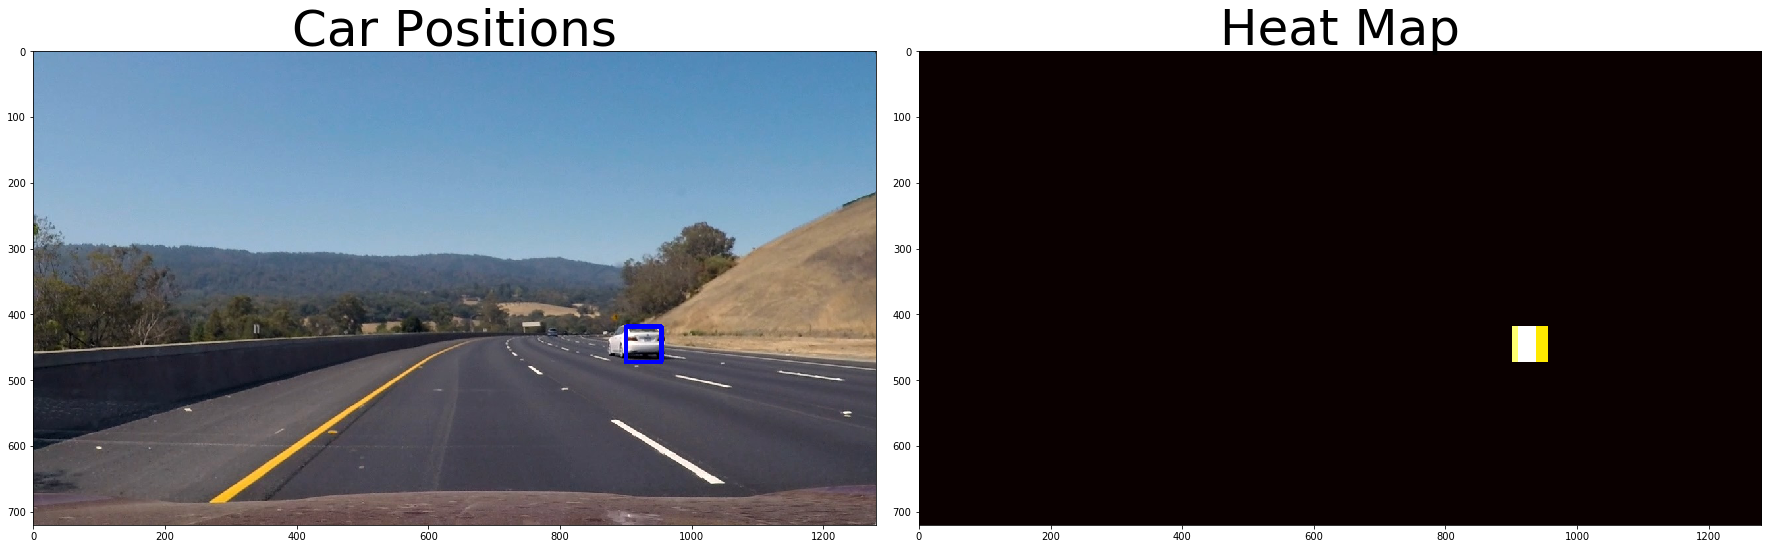

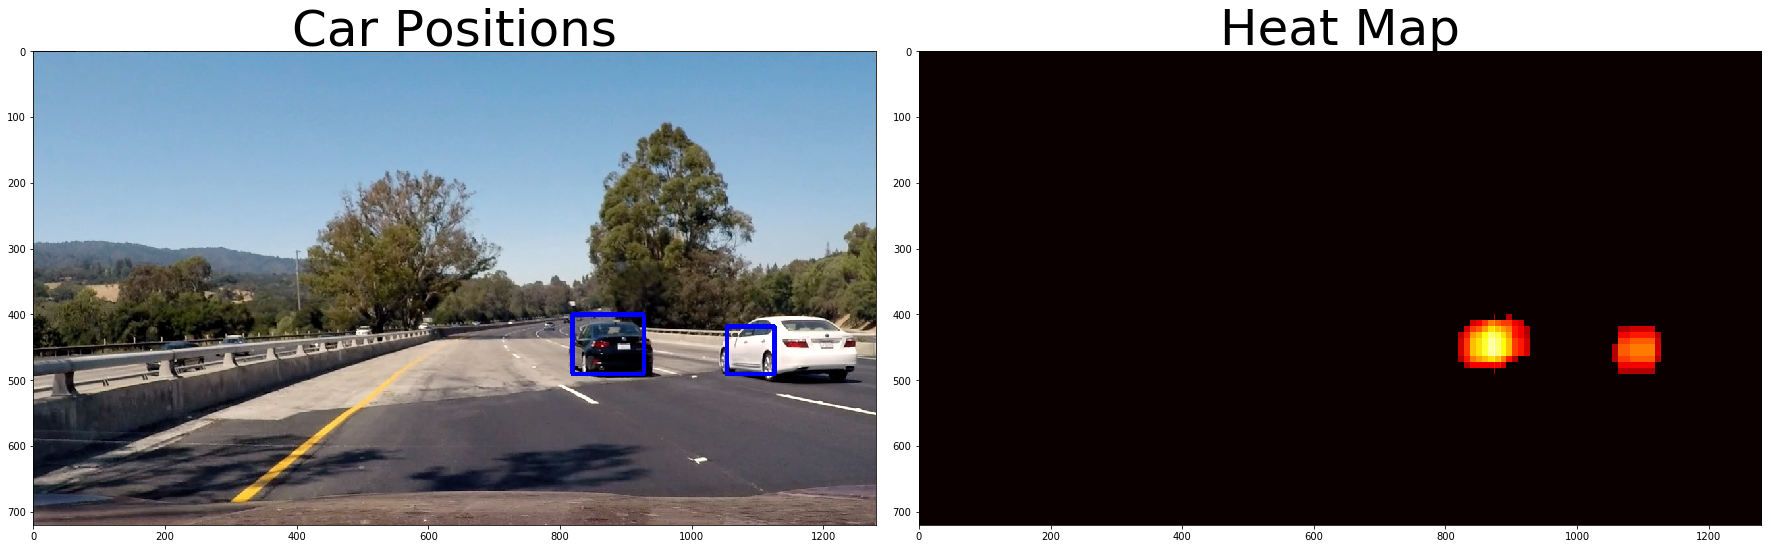

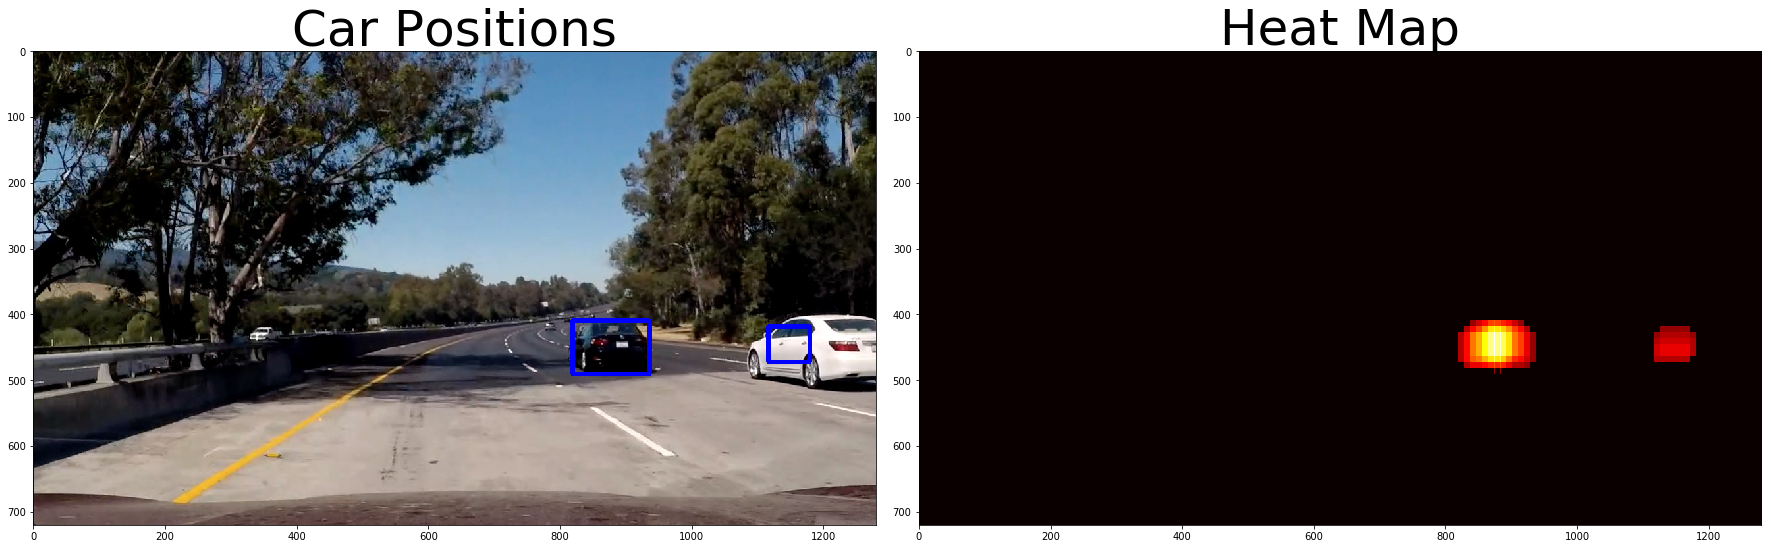

In [17]:
threshold = 4
img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, params)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, params)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[2]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, params)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[3]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, params)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[4]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, params)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Hog Sub-sampling Window Search

In [18]:
def find_cars_hog_sub(img, ystart, ystop, svc, scaler, params, cells_per_step = 1):
    draw_img = np.copy(img)
    cspace = params.color_space
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    
    if params.scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/params.scale), np.int(imshape[0]/params.scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (ch1.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    nfeat_per_block = params.orient*params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=params.spatial_size)
            hist_features = color_hist(subimg, nbins=params.hist_bins, bins_range=params.hist_range)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*params.scale )
                ytop_draw = np.int(ytop*params.scale )
                win_draw = np.int(window*params.scale )
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

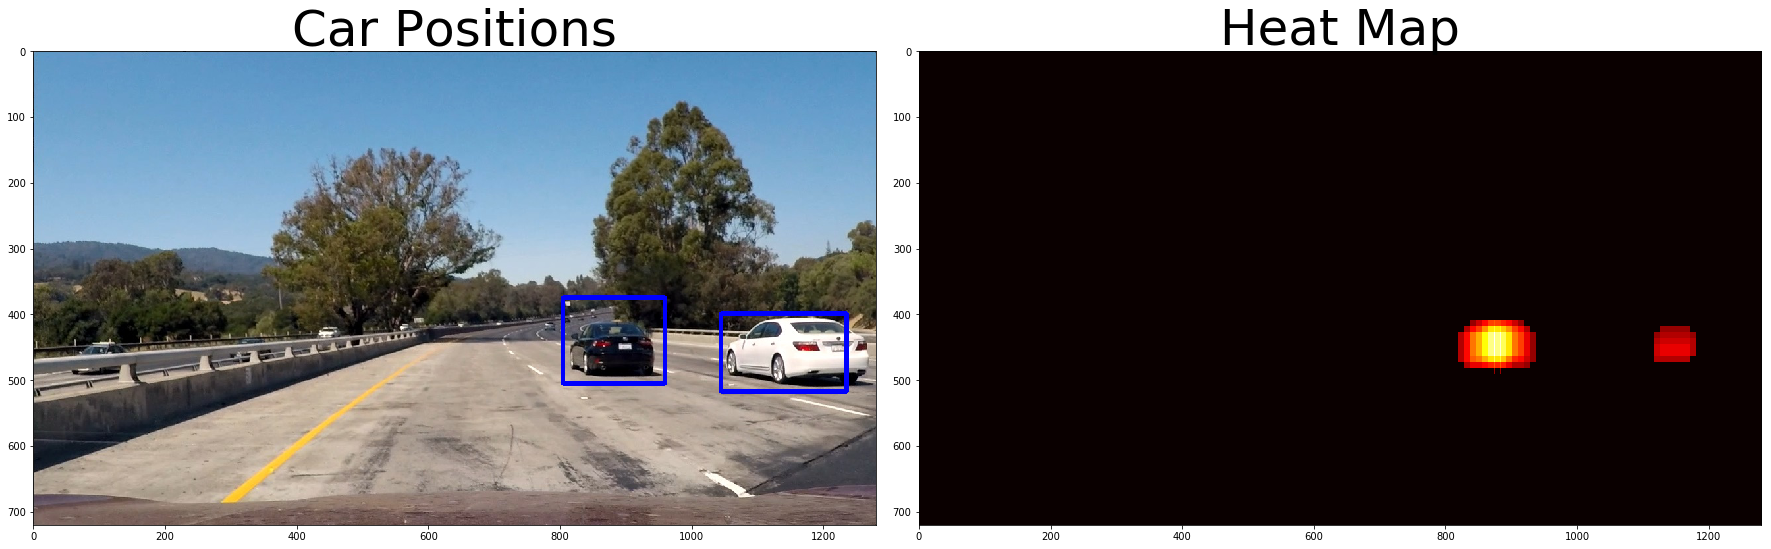

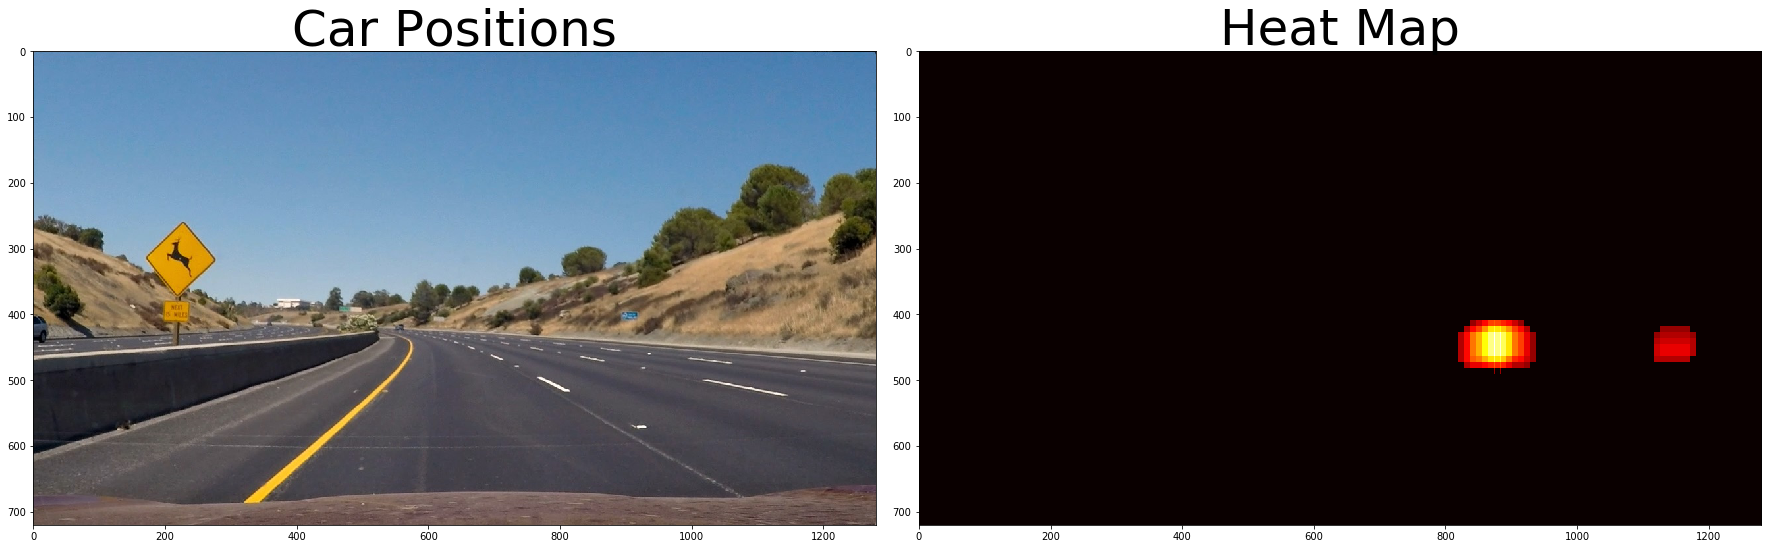

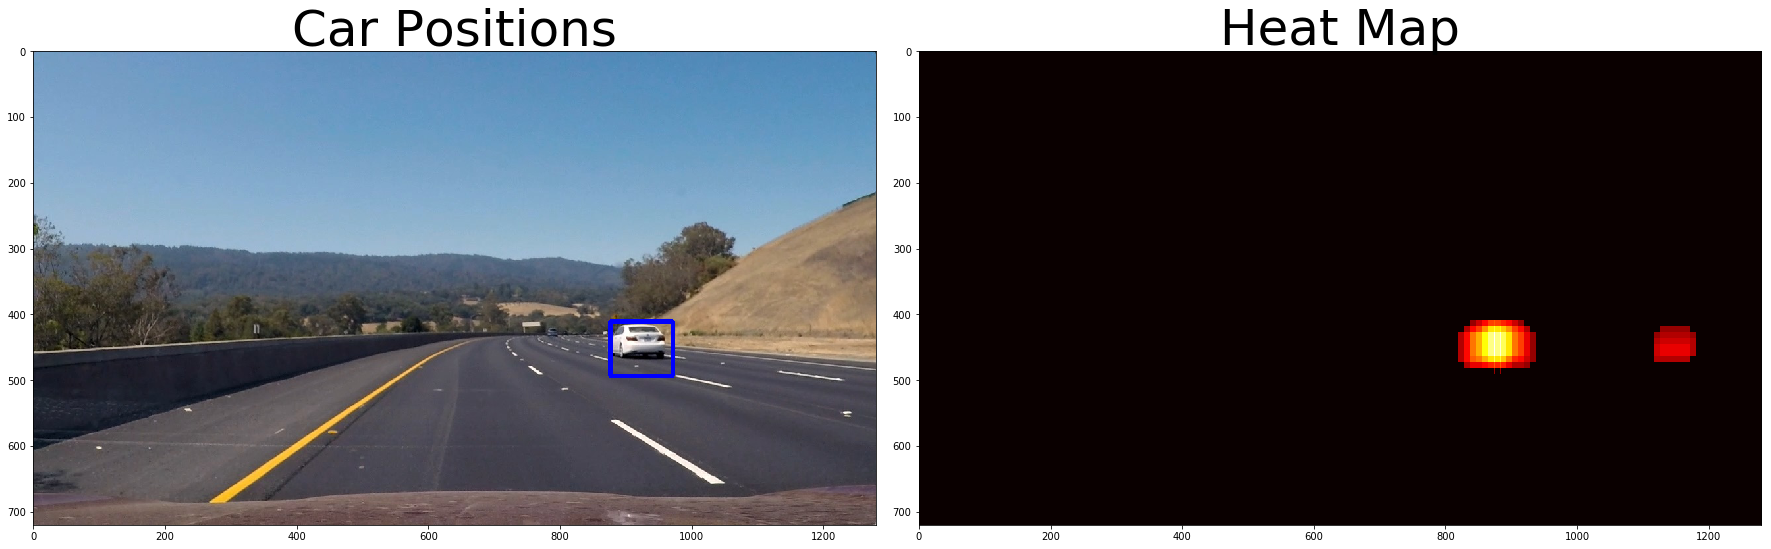

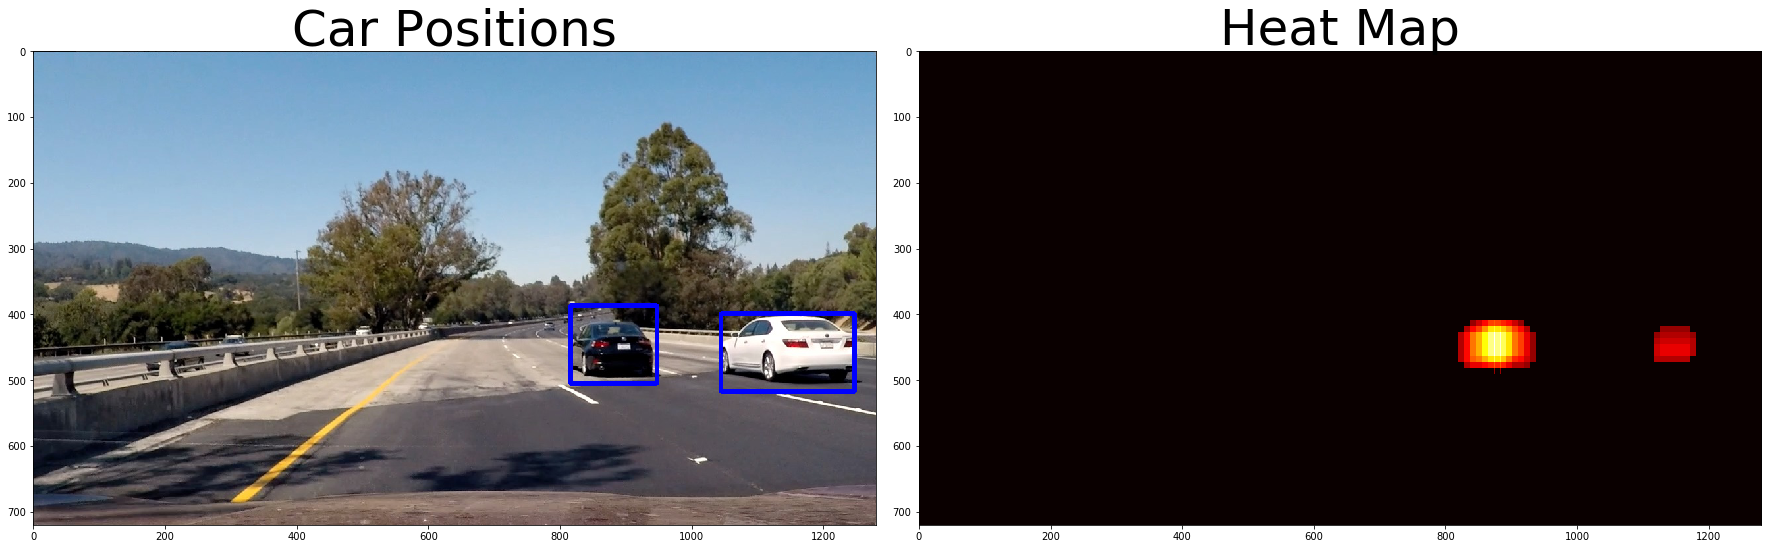

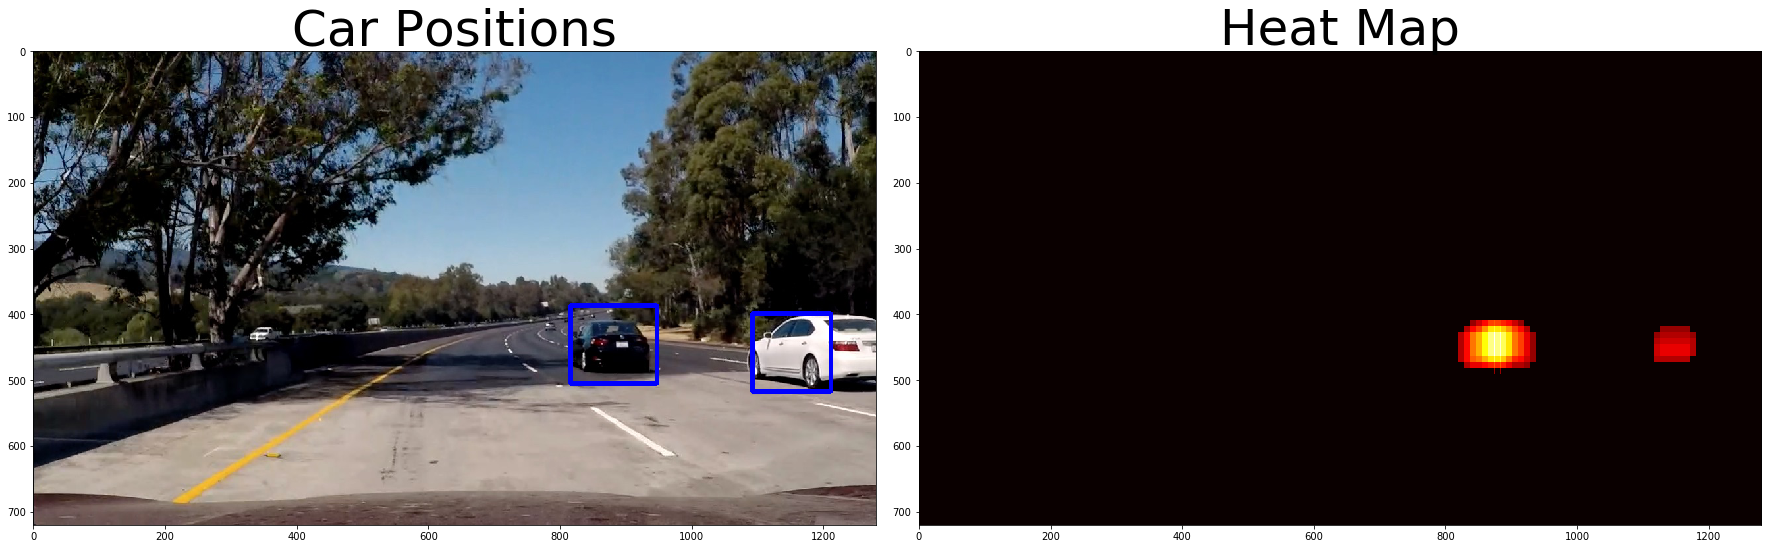

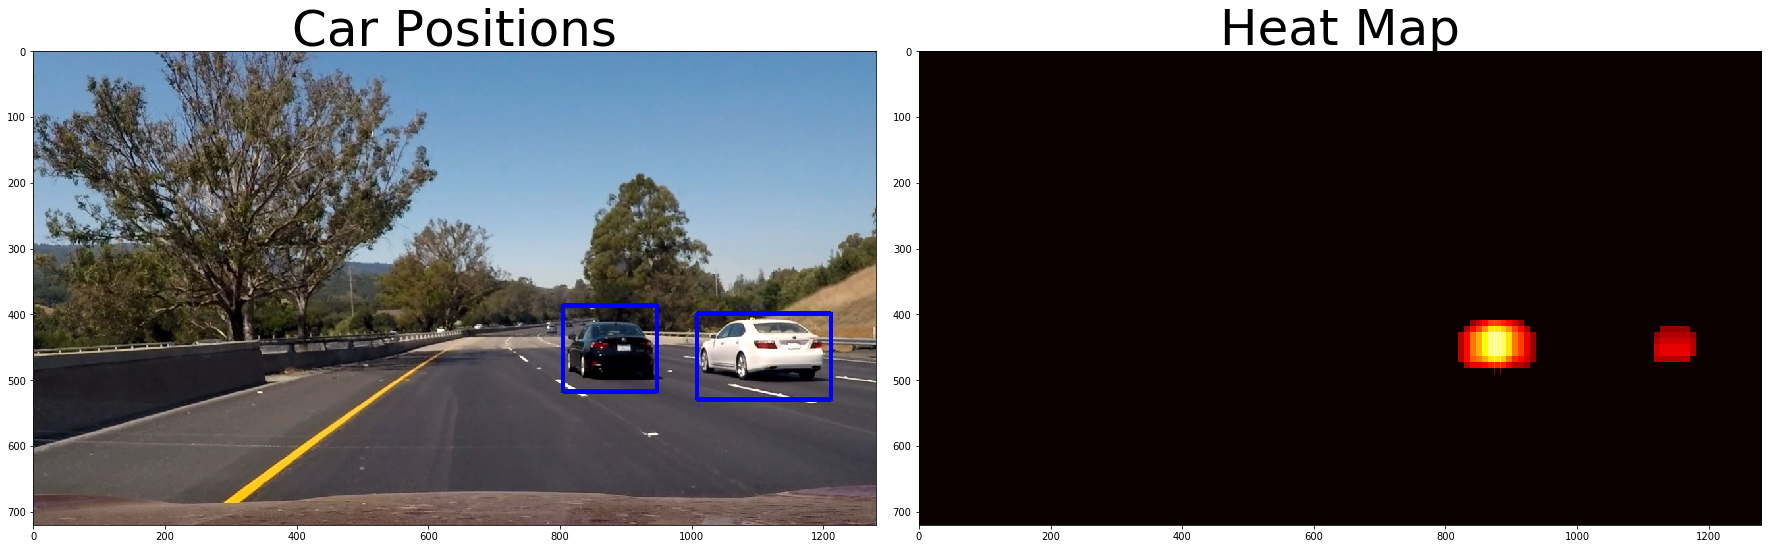

In [24]:
ystart = 350
ystop = 656

threshold = 2
img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[2]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[3]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[4]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = cv2.cvtColor(cv2.imread(test_images[5]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [25]:
def pipeline(img):
    ystart = 350
    ystop = 656
    threshold = 2 
    car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
    draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
    
    return draw_img

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:

def process_image(img):
    return pipeline(img)

white_output = 'output_video/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


  0%|          | 2/1261 [00:02<27:53,  1.33s/it]

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## optional challenge